[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/PCA.ipynb)

# Principal Component Analysis (PCA)
Consider having $N$ samples with $D$ features in $X \in \!R^{N \times D}$, with $D < N$.
In PCA we try to find an orthonormal transformation of data to a new coordinate. Using orthonormal $W \in \!R^{D \times D'}$ for the purpose we want
the projection to the first coordinate, have the highest variance, the second coordinate have the second highest and so on ...
Writing $X W$ for the coordinate transform, each column of $W$ denoted by $w$ maps $X$ to one of these coordinates; so the first coordinate is $X w_1 = z_1 \in \!R^{n}$. 
Maximizing the variance of projections in $z_1$ we get:
$$
\max_{w_1, ||w_1||_2=1} \frac{1}{N} z_1^\top z_1 = \max_{w_1, ||w_1||_2=1} \frac{1}{N} w_1^\top X^\top X w_1
$$
The constraint on the norm of $w_1$ comes from orthonormality of $W$ and in maximizing variance this way we have assumed each feature in $X$ has a zero mean.
In the above equation $\Sigma = \frac{1}{N} X^\top X$ is called *covariance matrix* (recall from the multivariate Gaussian lecture).
Covariance matrix is *positive semi-definite and symmetric*. Such matrices can be decomposed as 
$\Sigma = Q \Lambda Q^\top$ where $Q$ is orthonormal, containing eigenvectors, and $\Lambda$ has eigenvalues $\lambda_1,\ldots,\lambda_d$ on its diagonal. The maximization above becomes
$$
\max_{||w_1||_2=1} w_1^\top Q \Lambda Q^\top w_1 = \lambda_1
$$
where the maximizing $w_1$ is the first eigenvector $Q_{:,1}$. Similarly the second principal direction is the second eigenvector of the covariance matrix $C$, and so on ...
So eigenvectors give us the new coordinates, and since they are unit length we can project to them using product $X Q$.

Dimensionality reduction amounts to using the first $D' < D$ component in the new coordinates $X Q_{:,:D'}$, instead of $X$.
If we want to see what the compressed data looks like in the original coordinates we can use $Q^\top$ to move back to the original coordinate. In other words $||X - X Q_{:,:c} Q_{:,:c}^\top||_F$ gives us our compression error. 

Let's create simple 2D data and extract and perform PCA.

In [25]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [26]:
N = 20  # Number of data points

# Generate random data from standard normal distribution
# x0 has shape (N,) - first feature
x0 = np.random.randn(N)

# Create correlated second feature: x1 is linearly related to x0 plus noise
# 1.5*x0 creates correlation, randn(N) adds independent noise
# x1 has shape (N,)
x1 = 1.5*x0 + np.random.randn(N)

# Combine features into a data matrix
# np.column_stack stacks 1D arrays as columns
# x has shape (N, 2): N samples, 2 features (already zero-mean due to randn)
x = np.column_stack((x0, x1))

# Compute covariance matrix: C = (1/N) * X^T @ X
# x.T is (2, N), x is (N, 2)
# x.T @ x is (2, 2) - the unnormalized covariance matrix
# Division by N gives the covariance matrix
# c has shape (2, 2) and is symmetric positive semi-definite
c = x.T @ x / N

# Eigenvalue decomposition of covariance matrix
# For symmetric matrix C, we get C = Q * Lambda * Q^T where:
# lam: eigenvalues in ascending order, shape (2,)
# q: eigenvectors as columns (orthonormal), shape (2, 2)
# The eigenvector with largest eigenvalue is the first principal direction
lam, q = np.linalg.eigh(c)

Now lets plot the projections into the first and second principal direction. For this we project using $X Q_{:,1} Q_{:,1}^\top$ to get the coordinates in the original coordinate system.

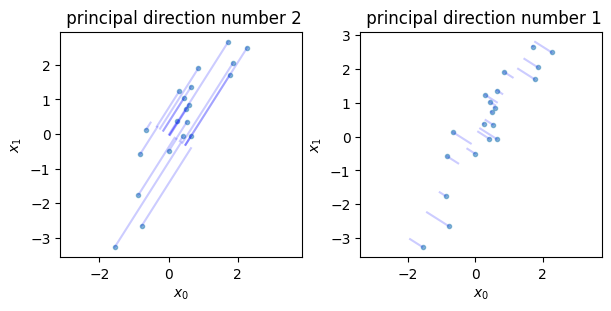

In [27]:
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(6, 3))

# Loop over 2 principal directions (0: second/smaller, 1: first/larger eigenvalue)
for d in range(2):
    # Project data onto d-th principal direction and back to original space
    # q[:,[d]] selects d-th column as (2,1) matrix (not 1D array) - important for matrix multiplication
    # The [d] with brackets keeps it 2D: shape (2, 1) instead of (2,)
    # x @ q[:,[d]] projects N points onto 1D line: (N,2) @ (2,1) = (N,1)
    # Multiplying by q[:,[d]].T maps back to original 2D space: (N,1) @ (1,2) = (N,2)
    # This gives coordinates of projected points in the original coordinate system
    xqqt = x @ q[:,[d]] @ q[:,[d]].T
    
    # Plot original data points in 2D
    # '.' creates point markers, alpha=.5 for semi-transparency
    axes[d].plot(x0, x1, '.', alpha=.5)
    
    # Draw lines from each original point to its projection
    for i in range(N):
        # x[i,0] is x0 coordinate of i-th point
        # x[i,1] is x1 coordinate of i-th point
        # xqqt[i,0] is x0 coordinate of i-th projected point
        # xqqt[i,1] is x1 coordinate of i-th projected point
        # This visualizes the projection distance (reconstruction error)
        axes[d].plot([x[i,0], xqqt[i,0]], [x[i,1], xqqt[i,1]], '-b', alpha=.2)
        axes[d].set_aspect('equal', 'datalim')
        # Note: 2-d reverses index because eigenvalues are in ascending order
        # d=0 corresponds to smaller eigenvalue (2nd principal direction)
        # d=1 corresponds to larger eigenvalue (1st principal direction)
        axes[d].set_title(f' principal direction number {2-d}')
        axes[d].set_xlabel(r'$x_0$')
        axes[d].set_ylabel(r'$x_1$')

plt.show()

## Singular Value Decomposition (SVD)

Another way to do PCA is using direct SVD decomposition of $X$ 
$$
X = \underbrace{U}_{n\times d} \underbrace{S}_{d\times d} \underbrace{V^\top}_{d \times d}
$$
To see the connection to derivation using the covariance matrix, note:
$$
\Sigma = \frac{1}{N}X^\top X = \frac{1}{N} V S U^\top U S V^\top = \frac{1}{N}  V S^2 V^\top =  Q \Lambda Q^\top
$$
Since the decomposition of $\Sigma$ in the form above is unique, the last equality means $V = Q$, and right singular vectors (columns of $V$) are the *principal directions*.
How about principal component coefficients? previously we got them using $X Q$ (or using a subset of columns of $Q$). However, this means
$$
X Q = U S V^\top V = U S
$$
To project back to original coordinates, similar to the previous derivation we multiply by $Q^\top = V^\top$ to get $U S V^\top = X$.

Therefore, if we zero some of the eigenvalues in $S$ we get the projections.

since $S$ is diagonal matrix, in `numpy.linalg.svd` it is returned in the form a vector.
Lets create simple 2D data and do some experiments.

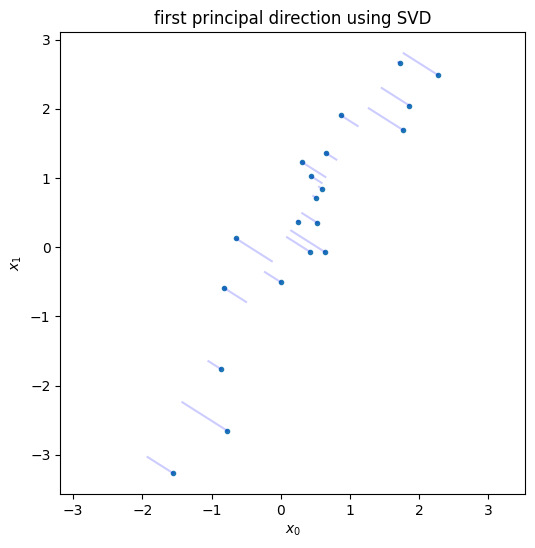

In [28]:
# Perform Singular Value Decomposition (SVD) on data matrix
# SVD decomposes: X = U @ S @ V^T where:
# u: left singular vectors, shape (N, 2) - orthonormal columns
# s: singular values (diagonal of S matrix) in descending order, shape (2,)
# vt: right singular vectors transposed, shape (2, 2) - orthonormal rows
# full_matrices=False returns economy-size decomposition (u is N x 2, not N x N)
# Note: columns of V (rows of vt) are the principal directions (same as eigenvectors q)
u, s, vt = np.linalg.svd(x, full_matrices=False)

# Create figure for better control
fig, ax = plt.subplots(figsize=(6, 6))

# Plot original data
ax.plot(x[:,0], x[:,1], '.', label='Original data')

# Zero out the second singular value to project onto first principal direction
# s[1] = 0 keeps only the largest component
# This is equivalent to dimensionality reduction to 1D
s[1] = 0

# Reconstruct data using only first principal component
# u @ np.diag(s) @ vt computes the low-rank approximation
# np.diag(s) converts vector s to diagonal matrix, shape (2, 2)
# u is (N, 2), diag(s) is (2, 2), vt is (2, 2)
# Result xh is (N, 2) - projected points in original coordinate system
xh = u @ np.diag(s) @ vt

# Draw lines from original points to their projections
for i in range(N):
    # This visualizes the reconstruction: how much information is lost
    # by using only the first principal component
    ax.plot([x[i,0], xh[i,0]], [x[i,1], xh[i,1]], '-b', alpha=.2)

ax.set_aspect('equal', 'datalim')
ax.set_title('first principal direction using SVD')
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')
plt.show()

## High dimensional data
When dealing with high-dimensional data we often do not need to produce all the principal directions. **Truncated SVD** can be much more efficient. 
Here, we continue to use `numpy`'s impelementation of SVD.

Let us use PCA for 2-dimensional embedding of `MNIST` digits.

In [29]:
# Load MNIST dataset: handwritten digits 0-9
# Each image is 28x28 pixels, flattened to 784 features
from sklearn.datasets import fetch_openml

# fetch_openml returns data and labels
# xorg has shape (70000, 784): 70000 images, 784 features (28*28 pixels)
# y contains string labels '0', '1', ..., '9'
# as_frame=False ensures we get numpy arrays instead of pandas DataFrames
xorg, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Keep original x, convert y to integers
# y.astype(int) converts strings to integers: '0'->0, '1'->1, etc.
# y has shape (70000,)
x, y = xorg, y.astype(int)

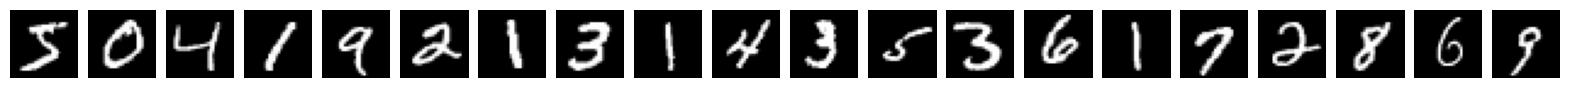

In [30]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_digits(data):
    """
    Plot MNIST digit images in a horizontal grid.
    
    Parameters:
    data: array of flattened images, shape (num_images, 784)
          Each row is a 28x28 image flattened to 784 pixels
    """
    num_plots = data.shape[0]  # Number of images to plot
    
    # Create figure with appropriate size
    # Fixed: was (num_plots, 10.*num_plots) which created huge figures
    fig = plt.figure(figsize=(num_plots, 2))
    
    # ImageGrid creates a grid of axes for displaying images
    # 111 means 1x1 grid, position 1 (standard subplot notation)
    # nrows_ncols=(1, num_plots) creates 1 row, num_plots columns
    # axes_pad=0.1 sets spacing between images
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    
    for i in range(num_plots):
        # data[i] selects i-th image: shape (784,)
        # reshape((28,28)) converts flattened vector back to 2D image
        # imshow displays the 2D array as a grayscale image
        grid[i].imshow(data[i].reshape((28,28)), cmap='gray')
        grid[i].axis('off')  # Hide axis for cleaner visualization
    
    plt.show()

# Visualize first 20 digits from the dataset
# x[:20] slices first 20 rows: shape (20, 784)
plot_digits(x[:20])

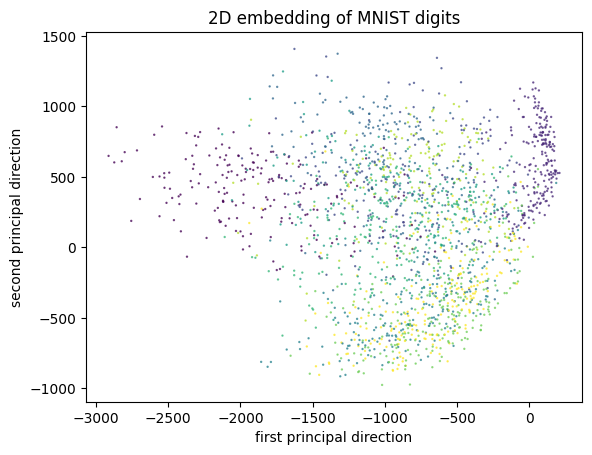

In [31]:
# Use subset of data for computational efficiency
# x[:2000] slices first 2000 images, shape (2000, 784)
x_small = x[:2000]

# Perform SVD on centered data
# np.mean(x_small, axis=0) computes mean along axis 0 (across samples)
# Result is shape (784,) - mean pixel value for each of 784 positions
# Broadcasting: (2000, 784) - (784,) = (2000, 784) centers the data
# SVD is performed on centered data to find principal directions
u, s, vt = np.linalg.svd(x_small - np.mean(x_small, axis=0))

# Project data onto principal components
# vt.T is (784, 2000) - transpose of right singular vectors
# x_small @ vt.T computes principal component scores
# Result pcs has shape (2000, 2000) but we only use first 2 columns
pcs = x_small @ vt.T

# Create 2D scatter plot colored by digit label
# pcs[:,0] is 1st principal component (highest variance), shape (2000,)
# pcs[:,1] is 2nd principal component (second highest variance), shape (2000,)
# c=y[:2000] colors points by their digit label (0-9)
# s=.5 sets small point size, alpha=.7 for transparency
plt.scatter(pcs[:,0], pcs[:,1], c=y[:2000], s=.5, alpha=.7)
plt.xlabel("first principal direction")
plt.ylabel("second principal direction")
plt.title("2D embedding of MNIST digits")
plt.show()

**Second example.**
Next let's only work with a single digit and more closely examine principal directions

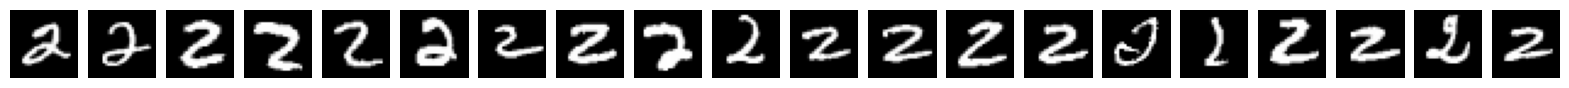

In [32]:
# Extract only digit '2' from the full dataset
# y.astype(int)==2 creates boolean mask: True where digit is 2, False otherwise
# Shape of mask: (70000,) with True/False values
# xorg[mask, :] selects rows where mask is True, keeps all columns
# Result x has shape (num_twos, 784) where num_twos ≈ 7000
x = xorg[y.astype(int)==2, :]

# Visualize first 20 examples of digit '2'
# x[:20] has shape (20, 784)
plot_digits(x[:20])

In [33]:
# Perform SVD on centered data
# x has shape (num_twos, 784)
# np.mean(x, axis=0) computes mean along samples: shape (784,)
# Broadcasting: (num_twos, 784) - (784,) centers each pixel
# After SVD:
# u: left singular vectors, shape (num_twos, 784)
# s: singular values in descending order, shape (784,)
# vt: right singular vectors transposed, shape (784, 784)
# Each row of vt is a principal direction (basis vector in 784-dim space)
u, s, vt = np.linalg.svd(x - np.mean(x, axis=0))

Let's plot the first twenty principal directions

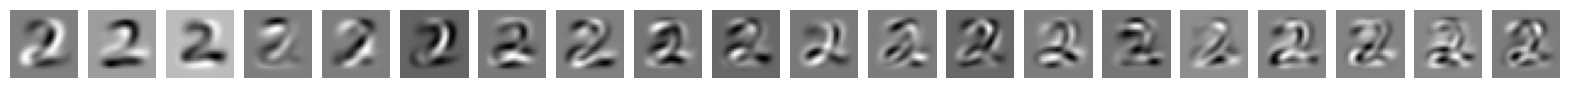

In [34]:
# Visualize the first 20 principal directions
# vt[:20] selects first 20 rows (principal components), shape (20, 784)
# Each row is a 784-dim vector that can be reshaped to 28x28 image
# These show the directions of maximum variance in the data
# For digit '2', these capture common variations (slant, thickness, etc.)
plot_digits(vt[:20])

We can also produce principal component coefficients for a new image:

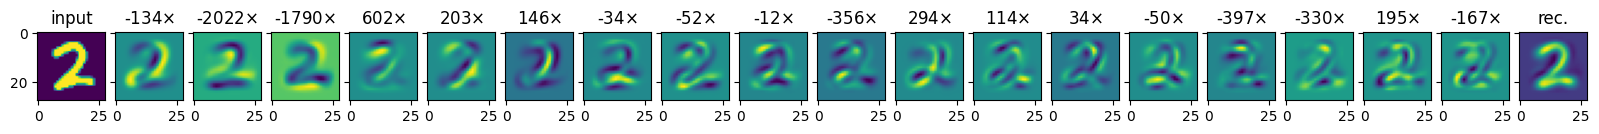

In [35]:
num_plots = 20

# Create figure for displaying reconstruction process
fig = plt.figure(figsize=(num_plots, 10.*num_plots))
grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)

# Select the last image from the dataset
# x[-1] has shape (784,) - last row of x
xn = x[-1]

# Compute principal component coefficients for this image
# xn @ vt.T projects the image onto all principal directions
# vt.T has shape (784, 784) so result is (784,)
# However, we only use the first num_plots-2 = 18 coefficients below
coefs = xn @ vt.T

# Display the original input image
# grid[0] is the first subplot in the grid
grid[0].imshow(xn.reshape((28,28)))
grid[0].set_title("input")

# Initialize reconstruction to zeros
# x_rec will accumulate the weighted sum of principal components
x_rec = np.zeros_like(xn)

# Build up the reconstruction incrementally
for i in range(num_plots-2):  # Loop through first 18 principal components
    # Compute coefficient for i-th principal component
    # xn.dot(vt[i]) projects xn onto i-th principal direction
    # vt[i] is shape (784,), dot product gives a scalar
    coef = xn.dot(vt[i])
    
    # Display the i-th principal component as an image
    # vt[i] has shape (784,), reshape to (28,28)
    grid[i+1].imshow(vt[i].reshape((28,28)))
    # Show the coefficient value (how much of this component is in xn)
    grid[i+1].set_title(f'{coef:.0f}'+r'$\times$')
    
    # Add this component's contribution to reconstruction
    # coef is a scalar, vt[i] is (784,)
    # Broadcasting: scalar * (784,) = (784,)
    # x_rec accumulates: x_rec = sum_{j=0}^{i} coef_j * vt[j]
    x_rec += coef * vt[i]

# Display the final reconstruction using first 18 components
# x_rec has shape (784,), reshape to (28,28) for display
# This approximates the original image using reduced dimensionality
grid[-1].imshow(x_rec.reshape((28,28)))
grid[-1].set_title('rec.')

plt.show()

## How many principal components to use?
To choose this number we can look at the variance of the data that is explained by each additional principal component $\frac{1}{N} \sum_n ({x^{(n)}}^\top v_i)^2$. Let's plot this for our digits example.

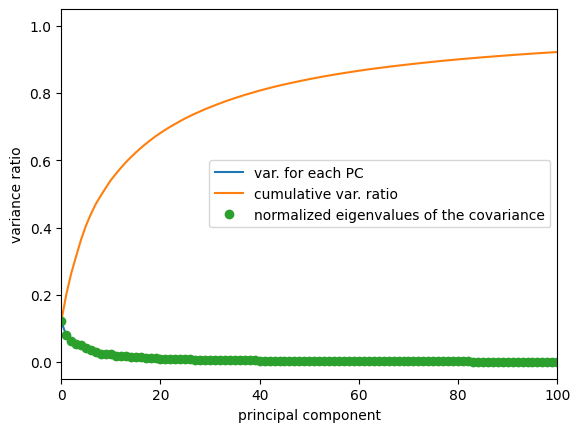

In [36]:
# Compute variance explained by each principal component

# Project data onto principal components
# x @ vt.T: (num_twos, 784) @ (784, 784) = (num_twos, 784)
# Each column is the projection onto one principal direction
# np.var(..., axis=0) computes variance along axis 0 (across samples)
# Result variances has shape (784,) - variance for each PC
variances = np.var(x @ vt.T, axis=0)

# Plot variance ratio for each principal component
# variances/np.sum(variances) normalizes so total sums to 1
# This shows fraction of total variance explained by each PC
plt.plot(variances/np.sum(variances), label="var. for each PC")

# Plot cumulative variance ratio
# np.cumsum computes running sum: [a, a+b, a+b+c, ...]
# Shows total variance explained using first k components
# Useful for choosing number of components (e.g., keep enough for 95% variance)
plt.plot(np.cumsum(variances/np.sum(variances)), label="cumulative var. ratio")

plt.xlabel("principal component")
plt.xlim([0,100])  # Focus on first 100 components
plt.ylabel("variance ratio")

# Verify relationship: variance of PC = (singular value)^2 / N
# s**2 computes squared singular values
# np.sum(s**2) is total variance
# (s**2)/(np.sum(s**2)) should equal variances/np.sum(variances)
# This confirms: eigenvalues of covariance matrix = (singular values)^2 / N
plt.plot((s**2)/(np.sum(s**2)), "o", label="normalized eigenvalues of the covariance")

plt.legend()
plt.show()

In [ ]:
# Verify that total variance is preserved under orthogonal transformation
# np.var(x, 0): variance of each pixel (feature) in original space, shape (784,)
# np.sum(...): total variance across all features
# variances: variance of each principal component, shape (784,)
# Since PCA uses orthogonal transformation, total variance is preserved
# This is a fundamental property: sum of eigenvalues = trace of covariance matrix
print(f'total variance in the original and new coordinates are equal: {np.sum(np.var(x, 0))}={np.sum(variances)}')

total variance in the original and new coordinates are equal: 3294564.838249081=3294564.838249082


We make several observations from the plot above:
- since we have are using an orthogonal transformation the total variance is the same under change of coordinate
- however in the new coordinate, coordinates with large index do not see much variance in the data
- so we can use the explained variance for picking $D'$

# Outlier detection

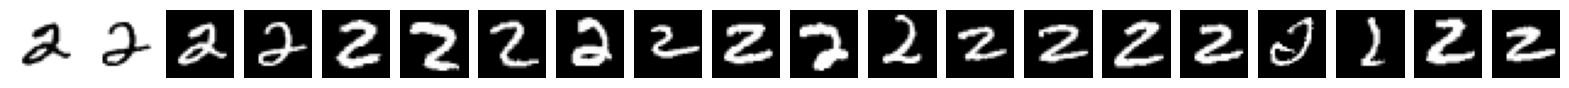

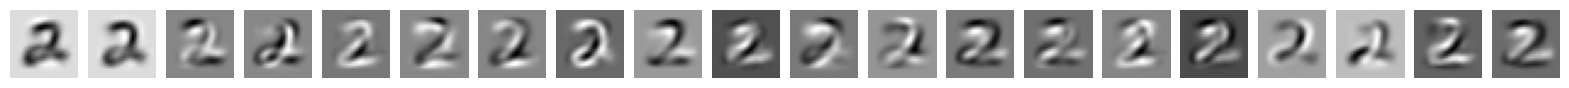

In [38]:
# Outlier detection example using PCA reconstruction error

# Select first 2000 examples of digit '2'
# Boolean indexing with multiple conditions:
# y.astype(int)==2 creates mask for digit 2
# [:2000,:] takes first 2000 rows, all 784 columns
x = xorg[y.astype(int)==2, :][:2000,:]

# Create outliers by inverting first 2 images
# 1-x inverts pixel values (assuming pixels in [0,1])
# Dark pixels become light, light becomes dark
# x[:2] selects first 2 images, shape (2, 784)
x_outliers = 1 - x[:2]

# Add outliers to the beginning of the dataset
# np.row_stack stacks arrays vertically (along axis 0)
# x_outliers is (2, 784), x is (2000, 784)
# Result x is (2002, 784) with outliers as first 2 rows
x = np.row_stack((x_outliers, x))

# Visualize dataset including outliers
# First 2 images (outliers) should look inverted
plot_digits(x[:20])

# Perform PCA on the full dataset (including outliers)
# Center data before SVD
u, s, vt = np.linalg.svd(x - np.mean(x,0))

# Project data onto principal components
# x @ vt.T: (2002, 784) @ (784, 784) = (2002, 784)
pcs = x @ vt.T

# Reconstruct using only first 10 principal components
# This is low-rank approximation for outlier detection
# u[:,:10]: first 10 left singular vectors, shape (2002, 10)
# s[:10]: first 10 singular values, shape (10,)
# np.diag(s[:10]): convert to diagonal matrix, shape (10, 10)
# vt[:10,:]: first 10 right singular vectors, shape (10, 784)
# Matrix multiplication: (2002,10) @ (10,10) @ (10,784) = (2002, 784)
rec = u[:,:10] @ np.diag(s[:10]) @ vt[:10,:]

# Visualize reconstructions
# Outliers should have poor reconstruction (high error)
# because they don't align well with principal components of normal '2's
plot_digits(rec[:20])

plt.show()

## Low-rank approximation using SVD
Matrix factorization methods have many applications in machine learning. SVD enables us to produce a low-rank approximation of a matrix.

(427, 640)


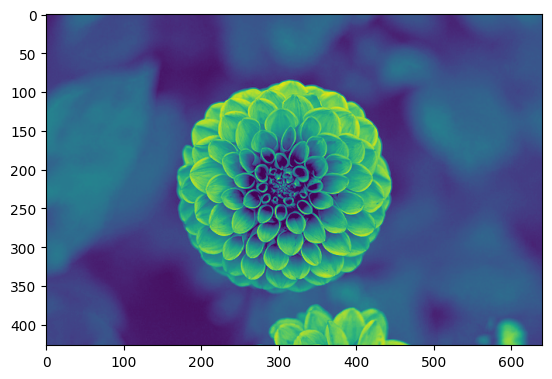

In [39]:
# Load sample images for low-rank approximation demo
from sklearn.datasets import load_sample_images

dataset = load_sample_images()

# Extract one color channel from the second sample image
# dataset.images is list of color images
# dataset.images[1] has shape (height, width, 3) for RGB channels
# [:,:,1] selects the green channel (index 1), resulting in 2D grayscale image
first_img_data = dataset.images[1]
x = first_img_data[:,:,1]

# Display original image dimensions
print(x.shape)

# Display the grayscale image
plt.imshow(x)
plt.show()

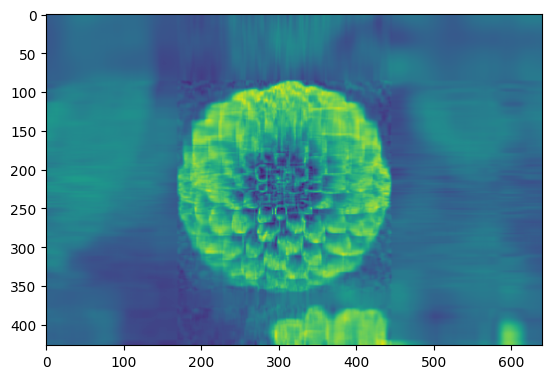

compression: from 273280 to 21340 
compression factor: 0.0780884074941452


(427, 640)

In [40]:
# Perform SVD for image compression
# For 2D matrix x with shape (height, width), SVD gives:
# x = u @ diag(s) @ vt where u, s, vt allow low-rank approximation
# full_matrices=False returns economy-size: u is (height, min(h,w))
u, s, vt = np.linalg.svd(x, full_matrices=False)

# Choose rank for compression
# Using only 'rank' singular values/vectors reduces storage
rank = 20

# Extract low-rank components
# uh: first 'rank' left singular vectors, shape (height, rank)
# sh: first 'rank' singular values, shape (rank,)
# vth: first 'rank' right singular vectors, shape (rank, width)
# Slicing [:, :rank] keeps first 'rank' columns
# Slicing [:rank, :] keeps first 'rank' rows
uh, sh, vth = u[:,:rank], s[:rank], vt[:rank, :]

# Reconstruct compressed image
# uh @ np.diag(sh) @ vth performs low-rank matrix multiplication
# np.diag(sh) converts vector to diagonal matrix, shape (rank, rank)
# (height, rank) @ (rank, rank) @ (rank, width) = (height, width)
# xh approximates x using only rank components instead of full rank
xh = uh @ np.diag(sh) @ vth

# Display compressed image
# Should look similar to original but with some loss of detail
plt.imshow(xh)
plt.show()

# Calculate compression statistics
# Original storage: height * width values
# Compressed storage: height*rank + rank + rank*width values
#   = rank * (height + width + 1) ≈ rank * (height + width)
# Compression factor < 1 means we use less space
print(f'compression: from {np.prod(x.shape)} to {rank*np.sum(x.shape)} \ncompression factor: {rank*np.sum(x.shape)/np.prod(x.shape)}')

x.shape